In [356]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.inspection import permutation_importance
from sklearn import tree, ensemble
from sklearn.tree import export_text
from sklearn.metrics import f1_score, recall_score

In [357]:
def preprocess(X, drop_cols, one_hot_cols):
    """
    Drop columns listed by drop_cols, turn one_hot_cols into 
    one-hot variables since decision trees must be fitted on numerical data.
    """
    X.drop(columns=drop_cols, inplace=True)
    one_hot = pd.get_dummies(X, columns=one_hot_cols, drop_first=True)
    return one_hot

def fit_and_score(X, y, method=None, depth=3):
    """ 
    Fit a decision tree using features X, labels y and maximum depth equal to depth. 
    Print out the ascii tree, accuracy, F1 score and return the model.
    """
    if method is None:
        # Use decision tree
        clf = tree.DecisionTreeClassifier(max_depth=depth)
    else:
        clf = method
    clf = clf.fit(X, y)
    if method is None:
        r = export_text(clf, feature_names=list(X.columns))
        print(r)
    print(f"In-sample precision:", clf.score(X, y))
    preds = clf.predict(X)
    print(f"In-sample recall score:", recall_score(y, preds))
    print(f"In-sample F1 score:", f1_score(y, preds))
    return clf
    
def oos_score(model, X, y):
    """
    Print accuracy and F1 score on (possibly) out-of-sample data for model.
    """
    print(f"Out-of-sample accuracy:", model.score(X, y))
    preds = model.predict(X)
    print(f"Out-of-sample F1 score:", f1_score(y, preds))
    
def nonnumeric(df):
    """
    Print out columns that contain NA or have dtype=object.
    """
    print("Columns with NA values:", df.isna().any()[lambda x: x])
    print("Columns with dtype=object", list(twibot_one_hot.select_dtypes(include='object')))
    
def mdi_feature_importance(clf, labels, ax):
    """
    Plot most important features.
    
    @param clf: fitted classifier
    """
    importances = clf.feature_importances_
    top10 = np.argsort(importances)[-10:] # Get top 10 most important features
    top10 = top10[::-1]
    std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
    mdi_importances = pd.Series(importances, index=labels)
    mdi_importances[top10].plot.bar(yerr=std[top10], ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    return mdi_importances

def permutation_feature_importance(ax, X, y, drop_cols):
    """
    Random forest feature importance on fitted model clf, features. Plot results on ax.
    Warning: computationally expensive, since refits model multiple times.
    """
    processed = preprocess(X, drop_cols, [])
    
    rf = ensemble.RandomForestClassifier(n_estimators=100)
    clf = fit_and_score(X, y, method=rf)

    pi = permutation_importance(clf, X, y, n_repeats=10, random_state=42, n_jobs=1)
    top10 = np.argsort(pi.importances_mean)[-10:] # Get top 10 most important features
    top10 = top10[::-1]
    pi_importances = pd.Series(pi.importances_mean, index=list(X.columns))
    pi_importances[top10].plot.bar(ax=ax)
    ax.set_title("Feature importances using permutation on full model")
    ax.set_ylabel("Mean accuracy decrease")

## cresci-2017

In [358]:
COLUMNS_TO_DROP = ['id', 
                   'name', 
                   'screen_name', 
                   'url', 
                   'profile_image_url', 
                   'profile_background_image_url_https', 
                   'description',
                   'profile_image_url_https', 
                   'profile_background_image_url', 
                   'created_at', 
                   'profile_text_color', 
                   'profile_sidebar_border_color', 
                   'profile_sidebar_fill_color', 
                   'profile_background_color', 
                   'profile_link_color']
DUMMY_COLUMNS = ['lang', 
                  'time_zone', 
                  'location', 
                  'default_profile', 
                  'default_profile_image', 
                  'utc_offset',
                  'is_translator', 
                  'default_profile', 
                  'default_profile_image', 
                  'profile_background_tile', 
                  'utc_offset',
                  'is_translator', 
                  'protected', 
                  'contributors_enabled', 
                  'geo_enabled',
                  'verified',
                  'profile_use_background_image']

In [359]:
# Load in data
folder_names = ['fake_followers', 
 'genuine_accounts', 
 'social_spambots_1', 
 'social_spambots_2', 
 'social_spambots_3', 
 'traditional_spambots_1', 
 'traditional_spambots_2', 
 'traditional_spambots_3',
 'traditional_spambots_4']
is_bot = [1, 0, 1, 1, 1, 1, 1, 1, 1]
dfs = []
cresci_labels = []
for name, ib in zip(folder_names, is_bot):
    df = pd.read_csv(f"./data/datasets_full.csv/{name}.csv/users.csv")
    dfs.append(df)
    cresci_labels.extend([ib]*len(df))

cresci2017 = pd.concat(dfs)

# Preprocess
cresci2017_one_hot = preprocess(cresci2017, 
                        COLUMNS_TO_DROP + ['profile_banner_url', 
                                                        'test_set_1', 
                                                        'test_set_2', 
                                                        'crawled_at',
                                                        'updated', 
                                                        'timestamp',
                                                        'following', 
                                                        'follow_request_sent'
                                                  ], 
                        DUMMY_COLUMNS + ['notifications',])

# Fit and score decision tree
fit_and_score(cresci2017_one_hot, cresci_labels, depth=1)

|--- favourites_count <= 16.50
|   |--- class: 1
|--- favourites_count >  16.50
|   |--- class: 0

In-sample precision: 0.9766146993318485
In-sample recall score: 0.9862309528180649
In-sample F1 score: 0.9846041055718475


DecisionTreeClassifier(max_depth=1)

In [360]:
# Fit and score on random forest
rf = ensemble.RandomForestClassifier(n_estimators=100)
rf_clf = fit_and_score(cresci2017_one_hot, cresci_labels, method=rf)

In-sample precision: 0.9999304008908686
In-sample recall score: 0.9999082063521204
In-sample F1 score: 0.9999541010694452


In-sample precision: 1.0
In-sample recall score: 1.0
In-sample F1 score: 1.0


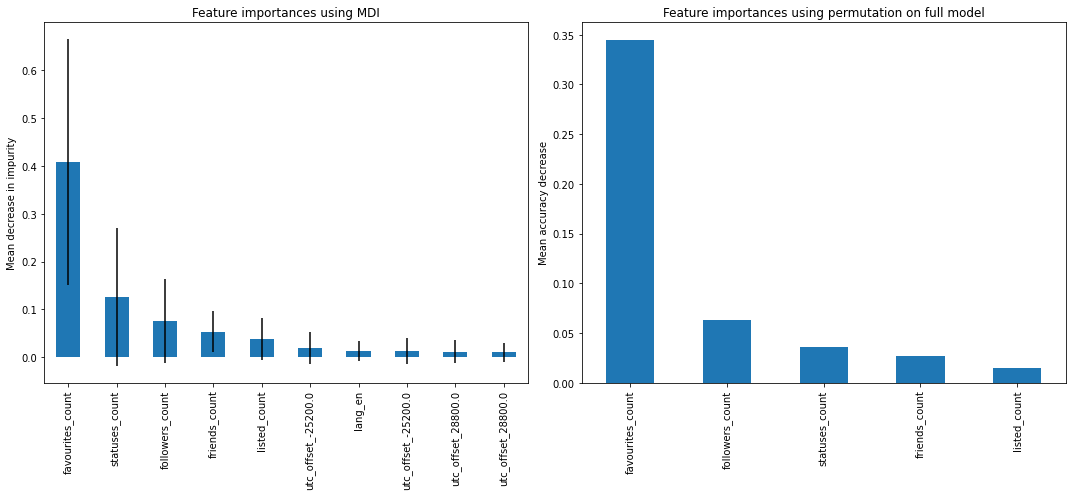

In [363]:
fig, axes = plt.subplots(1,2, figsize=(15,7))
mdi = mdi_feature_importance(rf_clf, list(cresci2017_one_hot.columns), axes[0])
permutation_feature_importance(axes[1], cresci2017, cresci_labels, DUMMY_COLUMNS + ['notifications',])
fig.tight_layout()

## TwiBot-20

In [371]:
# Load data
def load_twibot(path):
    with open(path) as f:
        twibot = json.load(f)
        twibot_labels = [int(ent['label']) for ent in twibot]
        profs = [ent['profile'] for ent in twibot]
        twibot_df = pd.DataFrame(profs)
    # Turn bool, string columns into ints
    for col in twibot_df:
        if (True in twibot_df):
            twibot_df[col] = twibot_df[col].astype(int)
        if (col in ['followers_count', 'friends_count', 'listed_count', 'favourites_count', 'statuses_count']):
            twibot_df[col] = twibot_df[col].astype(int)
        if (col in ['is_translation_enabled', 'has_extended_profile']):
            twibot_df[col] = twibot_df[col].astype(bool).astype(int) 
    twibot_one_hot = preprocess(twibot_df, COLUMNS_TO_DROP + ['profile_location', 'entities', 'id_str'], DUMMY_COLUMNS)
    return twibot_df, twibot_one_hot, twibot_labels

twibot_df, twibot_one_hot, twibot_labels = load_twibot("./data/Twibot-20/train.json")

In [372]:
# Fit and score on decision tree
dt_clf = fit_and_score(twibot_one_hot, twibot_labels, depth=1)

|--- verified_True  <= 0.50
|   |--- class: 1
|--- verified_True  >  0.50
|   |--- class: 0

In-sample precision: 0.8094950471128292
In-sample recall score: 0.9997847610848042
In-sample F1 score: 0.8548817520934942


In [373]:
# Fit and score on random forest
rf = ensemble.RandomForestClassifier(n_estimators=100)
rf_clf = fit_and_score(twibot_one_hot, twibot_labels, method=rf)

In-sample precision: 1.0
In-sample recall score: 1.0
In-sample F1 score: 1.0


In-sample precision: 1.0
In-sample recall score: 1.0
In-sample F1 score: 1.0


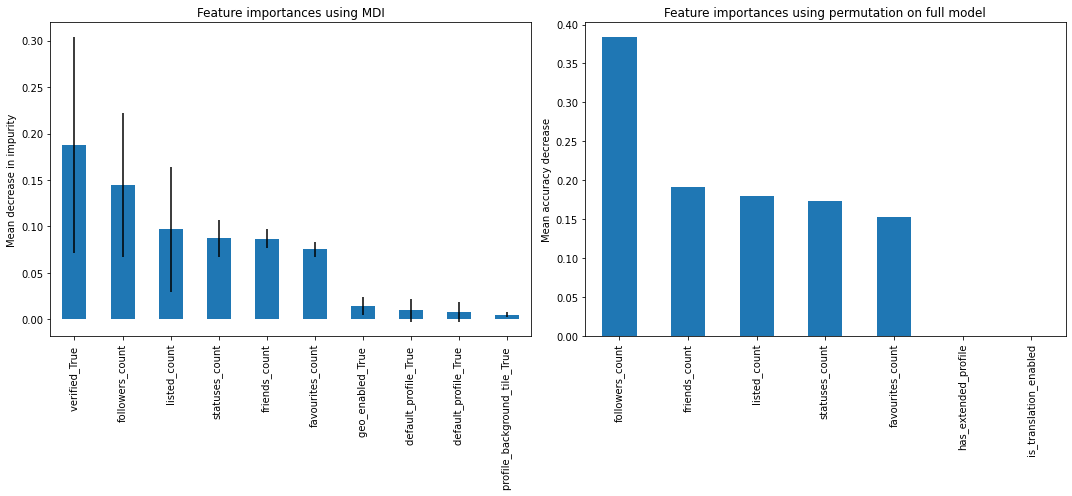

In [374]:
fig, axes = plt.subplots(1,2, figsize=(15,7))
mdi_feature_importance(rf_clf, list(twibot_one_hot.columns), axes[0])
permutation_feature_importance(axes[1], twibot_df, twibot_labels, DUMMY_COLUMNS)
fig.tight_layout()

## caverlee-2011

In [375]:
caverlee2011_bots = pd.read_csv("./data/social_honeypot_icwsm_2011/content_polluters.txt", sep="\t", header=0, names=["UserID", "CreatedAt", "CollectedAt", "NumerOfFollowings", "NumberOfFollowers", "NumberOfTweets", "LengthOfScreenName", "LengthOfDescriptionInUserProfile"])
caverlee2011_humans = pd.read_csv("./data/social_honeypot_icwsm_2011/legitimate_users.txt", sep="\t", header=0, names=["UserID", "CreatedAt", "CollectedAt", "NumerOfFollowings", "NumberOfFollowers", "NumberOfTweets", "LengthOfScreenName", "LengthOfDescriptionInUserProfile"])
caverlee2011 = pd.concat([caverlee2011_bots, caverlee2011_humans])
caverlee2011_labels = [1]*len(caverlee2011_bots) + [0]*len(caverlee2011_humans)


In [376]:
caverlee2011

,UserID,CreatedAt,CollectedAt,NumerOfFollowings,NumberOfFollowers,NumberOfTweets,LengthOfScreenName,LengthOfDescriptionInUserProfile
0,10836,2006-10-27 14:38:04,2010-06-18 03:35:34,1949,793,226,9,134
1,10997,2006-10-29 09:50:38,2010-04-24 01:12:40,1119,9644,38674,12,158
2,633293,2007-01-14 12:40:10,2010-01-24 11:59:38,2174,6029,12718,11,121
3,717883,2007-01-27 22:14:18,2010-02-06 06:25:58,7731,7029,873,6,70
4,763068,2007-02-10 10:51:38,2010-07-26 04:48:03,120,130,686,6,35
...,...,...,...,...,...,...,...,...
19270,93390990,2009-11-29 06:34:30,2009-11-29 07:50:54,5,0,5,11,0
19271,93402679,2009-11-29 07:47:50,2009-11-29 07:56:28,20,1,1,12,0
19272,93419256,2009-11-29 09:23:30,2009-11-29 09:30:48,0,0,1,8,0
19273,93426370,2009-11-29 10:04:26,2009-11-29 10:13:17,20,1,1,10,0


In [377]:
preprocess(caverlee2011, ['UserID', 'CollectedAt', 'CreatedAt'], [])

,NumerOfFollowings,NumberOfFollowers,NumberOfTweets,LengthOfScreenName,LengthOfDescriptionInUserProfile
0,1949,793,226,9,134
1,1119,9644,38674,12,158
2,2174,6029,12718,11,121
3,7731,7029,873,6,70
4,120,130,686,6,35
...,...,...,...,...,...
19270,5,0,5,11,0
19271,20,1,1,12,0
19272,0,0,1,8,0
19273,20,1,1,10,0


In [378]:
fit_and_score(caverlee2011, caverlee2011_labels, depth=2)

|--- NumerOfFollowings <= 232.50
|   |--- NumberOfTweets <= 65.50
|   |   |--- class: 1
|   |--- NumberOfTweets >  65.50
|   |   |--- class: 0
|--- NumerOfFollowings >  232.50
|   |--- NumberOfTweets <= 1087.50
|   |   |--- class: 1
|   |--- NumberOfTweets >  1087.50
|   |   |--- class: 1

In-sample precision: 0.8133841000554257
In-sample recall score: 0.9416344163441634
In-sample F1 score: 0.8438520788805098


DecisionTreeClassifier(max_depth=2)

In [379]:
rf = ensemble.RandomForestClassifier(n_estimators=100, max_depth=10)
rf_clf = fit_and_score(caverlee2011, caverlee2011_labels, method=rf, depth=2)

In-sample precision: 0.9245728606887245
In-sample recall score: 0.9399243992439924
In-sample F1 score: 0.9302957420274363


In-sample precision: 0.9993252524278864
In-sample recall score: 0.999279992799928
In-sample F1 score: 0.9993699369936995


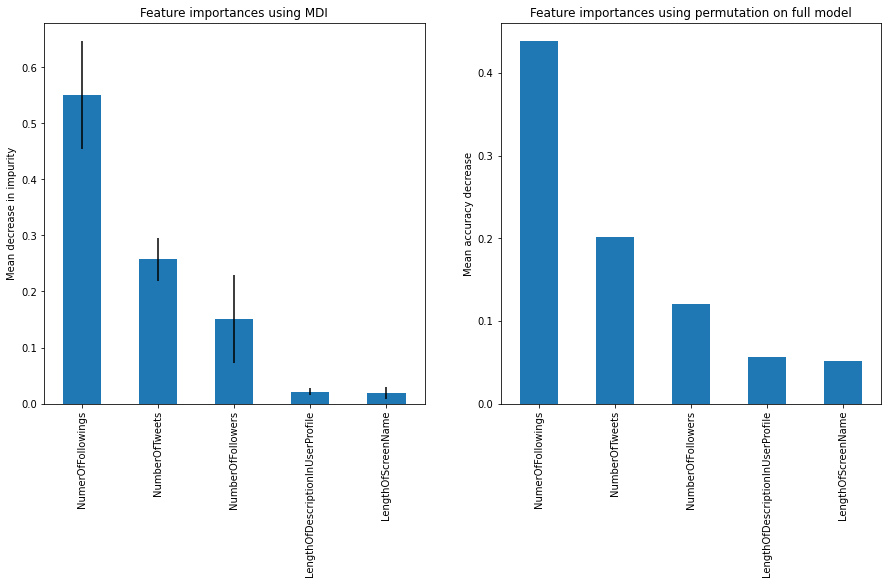

In [381]:
fig, axes =plt.subplots(1, 2, figsize=(15,7))
mdi_feature_importance(rf_clf, list(caverlee2011.columns), axes[0])
permutation_feature_importance(axes[1], caverlee2011, caverlee2011_labels, [])